<a href="https://colab.research.google.com/github/davidislip/SVM-and-MVO/blob/main/Joint_Optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Integration of SVM and MVO 
The idea is to integrate support vector machines and mean variance optimization 

$$
\begin{align} 
\min_{x, z, w} \quad & \lambda x^{\intercal}\Sigma x - \mu^\intercal x + \frac{1}{2}||{w}||^2 &\\ 
\textrm{s.t.} \quad & x_i \leq z_i \quad &\forall i = 1,2,...,N \\
              \quad & y_i^{\intercal} w \leq M z_i \quad & \forall i = 1,2,...,N \\
              \quad & -M(1-z_i) \leq  y_i^{\intercal} w \quad &\forall i = 1,2,...,N \\
              \quad & x \in \mathcal{C} \quad z \in \{0,1\}^N & \\
\end{align} 
$$

In [5]:
!sudo python -m pip install gurobipy==9.1.2

  Using cached gurobipy-9.1.2-cp37-cp37m-manylinux1_x86_64.whl (11.1 MB)
info  : grbgetkey version 9.1.2, build v9.1.1rc0-30-g8af970cb
info  : Contacting Gurobi license server...
error : ERROR 201: 609d27d4-85ae-4740-88bf-a1112c73a6cb not found


In [2]:
from google.colab import drive 
drive.mount('/content/gdrive')
import gurobipy as gp
from gurobipy import GRB
from math import sqrt
import sys
pth = 'gdrive/My Drive/Colab Notebooks/'
sys.path.append(pth + 'SVM MVO/PYFILES/')
from packages import *
%matplotlib inline

## Import Forecasts
forecasts = pd.read_pickle(pth +'SVM MVO/DATA/Forecasts.pkl')
## Import Returns
rets = pd.read_pickle(pth + 'SVM MVO/DATA/RETS.pkl')
## Import feature vectors
wrds_svm = pd.read_pickle(pth + 'SVM MVO/DATA/WRDS_ASOF.pkl')

Mounted at /content/gdrive


In [4]:
mth = rets.index[0]
mth

Timestamp('2000-07-01 00:00:00')

In [129]:
#this will be changed when I figure out the gurobi license (right now can only handle 200 quadratic variables)
#preprocessing 
cov_, mean_ = forecasts[mth]
N = 40
cov = cov_[:N,:N]
mean = mean_[:N,:]
tics = rets.columns[:N]
print("valid tickers:", tics)
#get the wharton research data for the valid tickers
wrds_tics = wrds_svm[wrds_svm.index.get_level_values('tic').isin(tics)].xs(mth, level="MonthStart")
#restrict the wharton research data to the columns of interest
Y = wrds_tics.loc[:,"ROC1":"GRW8"] # Y matrix in formulation 
Y_ =  (Y - Y.mean(axis=0))/(Y.std(axis=0))
Y_ = Y_.iloc[:,:]
Y_['bias'] = 1
#Y_

valid tickers: Index(['AAPL', 'ABC', 'ABMD', 'ABT', 'ADBE', 'ADI', 'ADM', 'ADP', 'ADSK',
       'AEE', 'AEP', 'AES', 'AJG', 'AKAM', 'ALB', 'ALK', 'AMAT', 'AMD', 'AME',
       'AMGN', 'AMT', 'AMZN', 'ANSS', 'AON', 'AOS', 'APA', 'APD', 'APH', 'ATO',
       'AVY', 'AZO', 'BA', 'BAX', 'BBY', 'BDX', 'BKNG', 'BLL', 'BMY', 'BSX',
       'BWA'],
      dtype='object')


### Simple Min Variance Portfolio 

In [119]:
# Create an empty model
m = gp.Model('portfolio')

# Add matrix variable for the stocks
x = m.addMVar(len(mean))

# Objective is to minimize risk (squared).  This is modeled using the
# covariance matrix, which measures the historical correlation between stocks
portfolio_risk = x @ cov @ x
m.setObjective(portfolio_risk, GRB.MINIMIZE)

# Fix budget with a constraint
m.addConstr(x.sum() == 1, 'budget')

# Verify model formulation
m.write('portfolio_selection_optimization.lp')

# Optimize model to find the minimum risk portfolio
m.optimize()

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads
Optimize a model with 1 rows, 40 columns and 40 nonzeros
Model fingerprint: 0x39fc15e8
Model has 820 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [5e-05, 7e-01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.02s
Presolved: 1 rows, 40 columns, 40 nonzeros
Presolved model has 820 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 39
 AA' NZ     : 7.800e+02
 Factor NZ  : 8.200e+02
 Factor Ops : 2.214e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   2.02804896e+05 -2.02804896e+05  3.62e+04 2.52e-05  1.00e+06     0s
   1   6.67895587e+04 -6.70324138e+04  1.86e+03 1

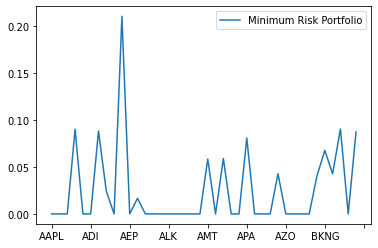

In [120]:
minrisk_volatility = sqrt(m.ObjVal)
minrisk_return = mean[:,0] @ x.X
results = pd.DataFrame(data=np.append(x.X, [minrisk_volatility, minrisk_return]),
             index=list(rets.columns[:N]) + ['Volatility', 'Expected Return'],
             columns=['Minimum Risk Portfolio'])
results
results.iloc[:-2].plot();

In [121]:
results

,Minimum Risk Portfolio
AAPL,9.133270e-11
ABC,1.201318e-10
ABMD,1.560599e-09
ABT,9.019338e-02
ADBE,1.225290e-10
ADI,3.615946e-08
ADM,8.828209e-02
ADP,2.420652e-02
ADSK,1.517909e-10
AEE,2.105833e-01


### Mean Variance and SVM Joint Formulation

In [130]:
N, m = Y_.shape
lam = 5
bigM = 100
# Create an empty model
model = gp.Model('SVM_MVO')

# Add matrix variable for the stocks
x = model.addMVar(N, lb = np.zeros(N))
x_list = x.tolist()
# Add support vector 
w = model.addMVar(m)
w_list = w.tolist()
# Add indicators 
z = model.addMVar(N, vtype=GRB.BINARY)
z_list = z.tolist()
# Objective is to minimize risk (squared).  This is modeled using the
# covariance matrix, which measures the historical correlation between stocks
portfolio_risk = lam* (x @ cov @ x) + (1/2)*(w @ w) - mean[:,0] @ x
model.setObjective(portfolio_risk, GRB.MINIMIZE)

# if z is zero then x must be zero
model.addConstr(x <= z, "z force x" ) 
#if x is close to zero then z must be zero 
model.addConstr(z <= 10*bigM*x, "z force x" ) 
# if z is zero then x must be zero
for i in range(N):
  y_i = Y_.iloc[i].values
  model.addConstr(w @ y_i <= -0.001 +  (bigM)*z[i], "svm1" ) 
  model.addConstr(-1*  (bigM) *(1 - z[i])  + 0.001 <= y_i @ w , "svm2" ) 

# Fix budget with a constraint
model.addConstr(x.sum() == 1, 'budget')

# Verify model formulation
model.write('portfolio_selection_optimization.lp')

# Optimize model to find the minimum risk portfolio
model.optimize()

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads
Optimize a model with 161 rows, 118 columns and 3320 nonzeros
Model fingerprint: 0x68e9d4fd
Model has 858 quadratic objective terms
Variable types: 78 continuous, 40 integer (40 binary)
Coefficient statistics:
  Matrix range     [6e-05, 1e+03]
  Objective range  [7e-03, 4e-01]
  QObjective range [3e-04, 3e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-03, 1e+02]
Found heuristic solution: objective 0.4153620
Presolve time: 0.00s
Presolved: 161 rows, 118 columns, 3320 nonzeros
Presolved model has 858 quadratic objective terms
Variable types: 78 continuous, 40 integer (40 binary)

Root relaxation: objective -1.383039e-01, 134 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   -0.13830    0   40    0.41536

In [131]:
w.X

array([0.        , 0.00197499, 0.00262443, 0.        , 0.00186244,
       0.00281037, 0.00084986, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.00014356,
       0.        , 0.00869874, 0.        , 0.        , 0.        ,
       0.        , 0.00728153, 0.00510761, 0.        , 0.00505178,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.0001149 , 0.        , 0.00220044, 0.00303612, 0.        ,
       0.        , 0.00075859, 0.        ])

In [132]:
Y_.columns

Index(['ROC1', 'ROC2', 'ROC3', 'ROC4', 'ROC5', 'INV1', 'INV2', 'INV3', 'PRO1',
       'PRO2', 'PRO3', 'PRO4', 'PRO5', 'PRO6', 'PRO7', 'LEV1', 'LEV2', 'LEV3',
       'LEV4', 'LEV5', 'RET1', 'LIQ1', 'LIQ2', 'LIQ3', 'LIQ4', 'LIQ5', 'RISK1',
       'RISK2', 'RISK3', 'GRW1', 'GRW2', 'GRW3', 'GRW4', 'GRW5', 'GRW6',
       'GRW7', 'GRW8', 'bias'],
      dtype='object')

In [133]:
z.X

array([-0.00000000e+00,  1.00000000e+00, -0.00000000e+00,  1.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,  1.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        1.00000000e+00,  1.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00,  9.53957906e-06,  1.00000000e+00,
       -0.00000000e+00,  1.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        1.00000000e+00,  1.00000000e+00,  1.00000000e+00, -0.00000000e+00,
       -0.00000000e+00,  1.00000000e+00, -0.00000000e+00, -0.00000000e+00])

In [134]:
x.X

array([0.        , 0.24918258, 0.        , 0.11378643, 0.        ,
       0.        , 0.        , 0.001     , 0.        , 0.        ,
       0.        , 0.        , 0.2955973 , 0.06803471, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.1550913 , 0.        , 0.001     ,
       0.        , 0.        , 0.001     , 0.001     , 0.001     ,
       0.        , 0.        , 0.11330768, 0.        , 0.        ])

In [135]:
np.matmul(Y_.values, w.X)

array([-1.53190500e-03,  1.63415499e-02, -1.00000000e-03,  1.00000000e-03,
       -1.00000000e-03, -6.31191677e-03, -1.00000000e-03,  1.07050328e-02,
       -1.00000000e-03, -4.22763216e-03, -1.00000000e-03, -2.91757298e-03,
        2.54197647e-02,  9.44196329e-03, -6.14515978e-03, -7.66308571e-03,
       -1.93329140e-03, -1.00000000e-03, -1.00000000e-03, -6.19183893e-03,
       -1.19881926e-03, -5.41918337e-03, -7.50078284e-03, -1.00000000e-03,
       -8.35496449e-03, -8.24208303e-03, -4.60420942e-05,  1.19186578e-02,
       -1.00000000e-03,  1.76253659e-03, -1.00000000e-03, -1.29524601e-03,
        2.87217242e-03,  1.36400116e-02,  1.83441702e-03, -1.00000000e-03,
       -1.00000000e-03,  1.12076077e-03, -4.12897432e-03, -1.09483689e-02])

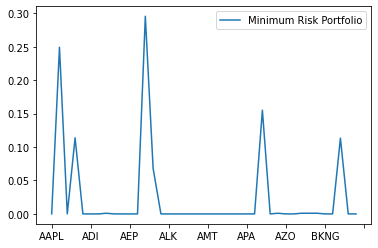

In [136]:
results2 = pd.DataFrame(data=np.append(x.X, [minrisk_volatility, minrisk_return]),
             index=list(rets.columns[:N]) + ['Volatility', 'Expected Return'],
             columns=['Minimum Risk Portfolio'])
results2
results2.iloc[:-2].plot();

In [117]:
results2

,Minimum Risk Portfolio
AAPL,0.000000
ABC,0.226767
ABMD,0.000000
ABT,0.000000
ADBE,0.000000
ADI,0.000000
ADM,0.000000
ADP,0.000000
ADSK,0.000000
AEE,0.000000


In [87]:
mean

array([[ 0.07271981],
       [ 0.27477976],
       [-0.15518335],
       [ 0.11789107],
       [ 0.13575763],
       [-0.08407297],
       [-0.08297169],
       [ 0.00718053],
       [-0.03894175],
       [-0.04304447],
       [-0.13565771],
       [ 0.06290918],
       [ 0.14471001],
       [ 0.40758457],
       [-0.08149147],
       [-0.07082925],
       [ 0.02214004],
       [-0.07392576],
       [-0.1367862 ],
       [ 0.10785153],
       [ 0.00827223],
       [-0.20929482],
       [ 0.01896374],
       [-0.0719679 ],
       [ 0.02061205],
       [ 0.05864437],
       [-0.06982479],
       [ 0.28216841],
       [-0.04938862],
       [ 0.04096284],
       [-0.18233664],
       [ 0.08937364],
       [ 0.07285177],
       [-0.03546648],
       [ 0.04857269],
       [-0.14566807],
       [ 0.03019753],
       [ 0.09419487],
       [-0.06542316],
       [-0.09406549],
       [-0.08608611],
       [ 0.18804296],
       [-0.09974793],
       [ 0.11541801],
       [-0.14939698],
       [ 0